Required Code Blocks Before Task 6 & Task 9

The following blocks must be executed before Task 6 (Classical ML Models) and Task 9 (Results, Window Size Sweep).
They provide all the data structures, preprocessing steps, and feature-extraction functions used by later tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq

plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["axes.grid"] = True 


In [2]:
def load_raw_sensor(pattern, prefix):
    files = glob.glob(pattern)
    dfs = []

    for path in files:
        df = pd.read_csv(
            path,
            header=None,
            names=["user", "activity", "timestamp", "x", "y", "z"]
        )
        df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)
        df[["x","y","z"]] = df[["x","y","z"]].astype(float)

        df = df.rename(columns={
            "x": f"{prefix}_x",
            "y": f"{prefix}_y",
            "z": f"{prefix}_z",
        })
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

# WATCH SENSORS
watch_acc  = load_raw_sensor("wisdm-dataset/raw/watch/accel/*.txt", "w_acc")
watch_gyro = load_raw_sensor("wisdm-dataset/raw/watch/gyro/*.txt",  "w_gyro")

# PHONE SENSORS
phone_acc  = load_raw_sensor("wisdm-dataset/raw/phone/accel/*.txt", "p_acc")
phone_gyro = load_raw_sensor("wisdm-dataset/raw/phone/gyro/*.txt",  "p_gyro")

# MERGE – use OUTER so we don’t lose rows
df_all = watch_acc.merge(watch_gyro, on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_acc,  on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_gyro, on=["user","activity","timestamp"], how="outer")

print(df_all.shape)
print(df_all["activity"].unique()[:20])  # first few activity codes


(9854871, 15)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'P' 'Q' 'R' 'S']


In [3]:
hand_activities = [
    "P",  # dribbling
    "O",  # playing catch
    "F",  # typing
    "Q",  # writing
    "R",  # clapping
    "G",  # brushing teeth
    "S",  # folding clothes
    "J",  # eating pasta
    "H",  # eating soup
    "L",  # eating sandwich
    "I",  # eating chips
    "K"   # drinking
]

df_all["activity"] = df_all["activity"].astype(str).str.strip()
df_hand = df_all[df_all["activity"].isin(hand_activities)].copy()
df_hand = df_hand.reset_index(drop=True)

df_hand["activity"].value_counts()


activity
P    572389
K    571651
O    566768
H    548889
S    548165
R    547468
G    545602
I    543510
L    535868
Q    531434
F    517955
J    509715
Name: count, dtype: int64

In [4]:
FS = 20
sensor_cols = [
    "w_acc_x","w_acc_y","w_acc_z",
    "w_gyro_x","w_gyro_y","w_gyro_z",
    "p_acc_x","p_acc_y","p_acc_z",
    "p_gyro_x","p_gyro_y","p_gyro_z"
]


In [5]:
def butter_lowpass_filter(x, cutoff=5, fs=FS, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low")
    return filtfilt(b, a, x)

df_raw = df_hand.copy()

# Interpolate missing values and apply low-pass filter
for col in sensor_cols:
    df_hand[col] = df_hand[col].interpolate(method="linear")
    df_hand[col] = butter_lowpass_filter(df_hand[col].values)


In [6]:
def create_windows(df, window_size=180, overlap=0.5):
    step = int(window_size * (1.0 - overlap))
    X, y = [], []

    signals = df[sensor_cols].values
    acts = df["activity"].values

    for start in range(0, len(df) - window_size, step):
        end = start + window_size
        window = signals[start:end]
        label = pd.Series(acts[start:end]).mode()[0]

        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)


In [7]:
windows, labels = create_windows(df_hand, window_size=180, overlap=0.5)
windows.shape, labels.shape


((72659, 180, 12), (72659,))

In [8]:
def time_features_1d(x):
    mean = np.mean(x)
    sd   = np.std(x)
    rms  = np.sqrt(np.mean(x**2))

    signs = np.sign(x)
    signs[signs == 0] = 1
    zcr = np.sum(signs[1:] != signs[:-1]) / len(x)

    return [mean, sd, rms, zcr]

def freq_features_1d(x, fs=FS):
    N = len(x)
    yf = rfft(x)
    xf = rfftfreq(N, 1.0 / fs)

    power = np.abs(yf) ** 2

    idx = np.argmax(power[1:]) + 1
    dom_freq = xf[idx]

    energy = np.sum(power)

    p = power / (energy + 1e-12)
    entropy = -np.sum(p * np.log(p + 1e-12))

    return [dom_freq, energy, entropy]


In [9]:
def extract_features_window(window):
    feats = []
    for c in range(window.shape[1]):  # 12 channels
        x = window[:, c]
        feats.extend(time_features_1d(x))
        feats.extend(freq_features_1d(x))
    return np.array(feats)


In [10]:
X = np.array([extract_features_window(w) for w in windows])
y = labels

X.shape, len(y)


((72659, 84), 72659)

In [11]:
feature_names = []

for ch in sensor_cols:
    for f in ["mean", "std", "rms", "zcr", "domfreq", "spec_energy", "spec_entropy"]:
        feature_names.append(f"{ch}_{f}")

len(feature_names)


84

## **Task 6 — Modeling**

In this task, we implemented and evaluated several **classical machine learning models** and prepared the dataset for **deep learning** experiments.

### **1. Data Cleaning and Preprocessing**
Before training, we identified and removed any **fully missing (NaN) feature columns**.
All infinite values were replaced with NaNs to ensure compatibility with imputers.  
A `SimpleImputer` (median or mean) was included in each model pipeline to handle missing data consistently.

### **2. Model Setup**
We trained and compared six classical machine learning models:

- **Decision Tree**
- **Support Vector Machine (RBF kernel)**
- **Gaussian Naive Bayes**
- **Random Forest**
- **AdaBoost**
- **XGBoost** (installed and added conditionally)

Each model was implemented using `scikit-learn` pipelines that included preprocessing steps such as imputation and standardization (for SVM).  
A **stratified 80/20 train–test split** was applied to maintain class balance across splits.

### **3. Training and Evaluation**
All models were trained on the same data split for fair comparison.  
A shared evaluation function was used to:
- Compute **accuracy**, **macro-F1**, and **weighted-F1** scores  
- Generate detailed **classification reports**  
- Plot **confusion matrices** for each model  

The overall results were compiled into a **leaderboard**, sorted by macro-F1 and accuracy.  
Performance metrics were visualized using bar plots for easier comparison.

### **4. Deep Learning Input Preparation**
To extend the preprocessing pipeline for deep learning:
- Raw sensor **window sequences** (`windows` array of shape *(N, T, C)*) were normalized **per channel** using global mean and standard deviation.  
- Labels were **encoded** (integer + one-hot) for compatibility with neural network frameworks.  
- The data was split into **training (70%)**, **validation (15%)**, and **test (15%)** sets while preserving class balance.  

Metadata such as class names, number of classes, sequence length, and normalization statistics were stored for later use in ANN models.

### **5. Summary**
- Implemented and evaluated six classical machine learning models.  
- Ensured consistent preprocessing (imputation, scaling, encoding).  
- Compared model performances using macro-F1 and accuracy.  
- Prepared normalized sequential data and encoded labels for deep learning.  
- Generated a leaderboard and visualizations to summarize results.  



In [12]:
import numpy as np
import pandas as pd

# Identify fully-missing columns
mask_all_nan = np.all(np.isnan(X), axis=0)
print("Columns fully NaN:", np.where(mask_all_nan)[0])

# Drop them
X = X[:, ~mask_all_nan]
feature_names = np.array(feature_names)[~mask_all_nan]
print("New X shape:", X.shape)


Columns fully NaN: [42 43 44 47 48 49 50 51 54 55 56 57 58 61 62 63 64 65 68 69 70 71 72 75
 76 77 78 79 82 83]
New X shape: (72659, 54)


In [13]:
import importlib, subprocess, sys

try:
    import xgboost
    print(" XGBoost already installed:", xgboost.__version__)
except ImportError:
    print(" Installing XGBoost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost
    print("XGBoost installed:", xgboost.__version__)


 XGBoost already installed: 3.1.2


(58127, 54) (14532, 54)  | classes: ['F' 'G' 'H' 'I' 'J' 'K' 'L' 'O' 'P' 'Q' 'R' 'S']

Model: DecisionTree
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9287    0.9497    0.9391      1152
           G     0.9180    0.9415    0.9296      1213
           H     0.8670    0.8670    0.8670      1218
           I     0.8317    0.8227    0.8272      1207
           J     0.8569    0.8554    0.8561      1134
           K     0.8585    0.8592    0.8588      1271
           L     0.8005    0.7884    0.7944      1191
           O     0.9251    0.9324    0.9287      1258
           P     0.9453    0.9505    0.9479      1273
           Q     0.9244    0.9221    0.9233      1181
           R     0.9622    0.9433    0.9527      1216
           S     0.9277    0.9163    0.9219      1218

    accuracy                         0.8960     14532
   macro avg     0.8955    0.8957    0.8956     14532


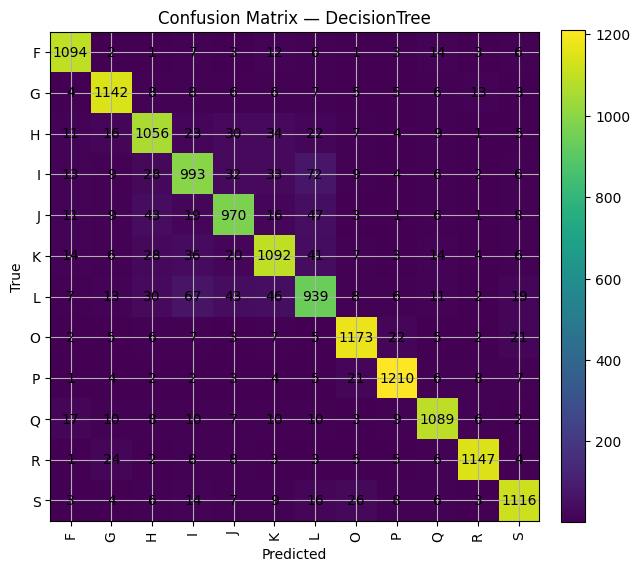


Model: SVM_RBF
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.7186    0.7891    0.7522      1152
           G     0.8190    0.7387    0.7768      1213
           H     0.6650    0.6404    0.6524      1218
           I     0.6786    0.6437    0.6607      1207
           J     0.6034    0.6949    0.6459      1134
           K     0.5668    0.7246    0.6360      1271
           L     0.6603    0.5810    0.6181      1191
           O     0.8644    0.8466    0.8554      1258
           P     0.9009    0.9356    0.9179      1273
           Q     0.8230    0.7832    0.8026      1181
           R     0.8324    0.7558    0.7922      1216
           S     0.8739    0.7849    0.8270      1218

    accuracy                         0.7445     14532
   macro avg     0.7505    0.7432    0.7448     14532
weighted avg     0.7517    0.7445    0.7460     14532



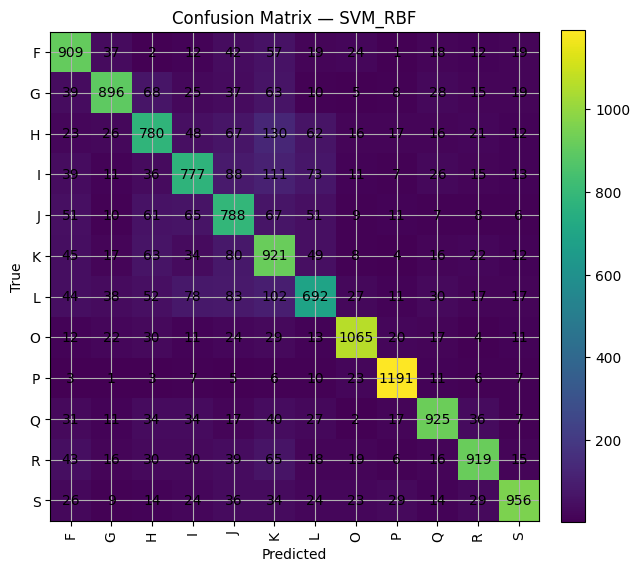


Model: NaiveBayes_Gaussian
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.0894    0.0234    0.0371      1152
           G     0.2379    0.0610    0.0971      1213
           H     0.0893    0.0443    0.0592      1218
           I     0.0429    0.0050    0.0089      1207
           J     0.1255    0.8536    0.2188      1134
           K     0.1017    0.2211    0.1394      1271
           L     0.0123    0.0008    0.0016      1191
           O     0.4410    0.1010    0.1643      1258
           P     0.5211    0.3983    0.4515      1273
           Q     0.1553    0.0288    0.0486      1181
           R     0.3386    0.1587    0.2161      1216
           S     0.2430    0.1133    0.1545      1218

    accuracy                         0.1658     14532
   macro avg     0.1998    0.1674    0.1331     14532
weighted avg     0.2028    0.1658    0.1349     14532



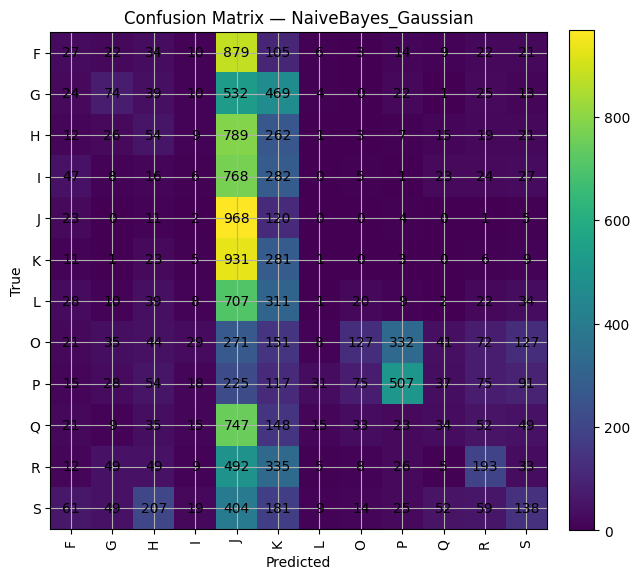


Model: RandomForest
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9519    0.9792    0.9653      1152
           G     0.9874    0.9720    0.9796      1213
           H     0.9368    0.9368    0.9368      1218
           I     0.9095    0.8989    0.9042      1207
           J     0.9101    0.9374    0.9235      1134
           K     0.9184    0.9292    0.9237      1271
           L     0.9247    0.8556    0.8888      1191
           O     0.9746    0.9777    0.9762      1258
           P     0.9849    0.9749    0.9799      1273
           Q     0.9612    0.9661    0.9637      1181
           R     0.9860    0.9844    0.9852      1216
           S     0.9390    0.9737    0.9561      1218

    accuracy                         0.9490     14532
   macro avg     0.9487    0.9488    0.9486     14532
weighted avg     0.9490    0.9490    0.9488     14532



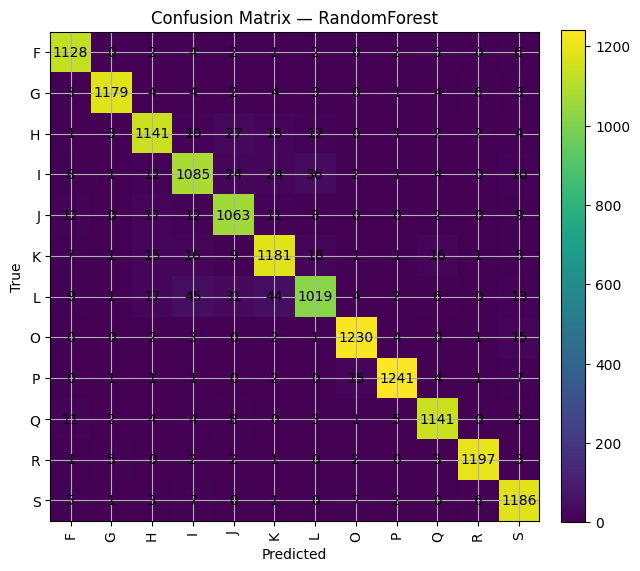

c:\Users\hanna\Downloads\CS156-main\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Model: AdaBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.2751    0.3785    0.3186      1152
           G     0.4814    0.2770    0.3516      1213
           H     0.1798    0.3071    0.2268      1218
           I     0.3384    0.2568    0.2920      1207
           J     0.3658    0.2751    0.3140      1134
           K     0.2328    0.4209    0.2998      1271
           L     0.1186    0.0546    0.0748      1191
           O     0.2848    0.1073    0.1559      1258
           P     0.4037    0.5381    0.4613      1273
           Q     0.4499    0.3954    0.4209      1181
           R     0.4610    0.2969    0.3612      1216
           S     0.2817    0.3612    0.3165      1218

    accuracy                         0.3066     14532
   macro avg     0.3227    0.3057    0.2995     14532
weighted avg     0.3226    0.3066    0.2996     14532



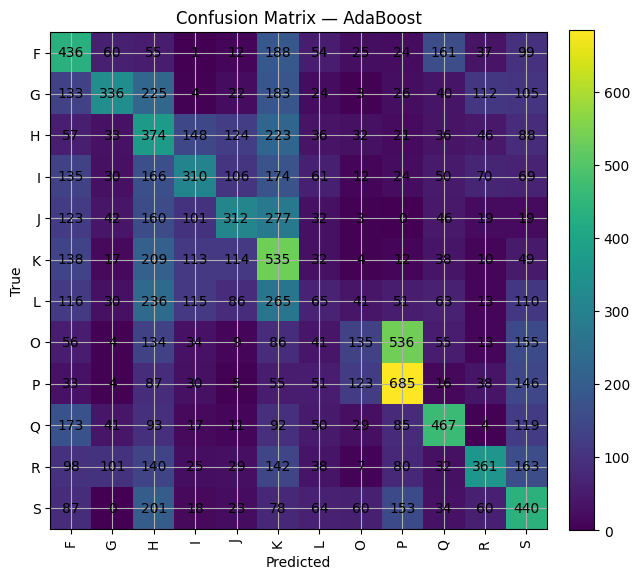


Model: XGBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9566    0.9766    0.9665      1152
           G     0.9824    0.9654    0.9738      1213
           H     0.9336    0.9228    0.9282      1218
           I     0.8889    0.8882    0.8885      1207
           J     0.8957    0.9242    0.9097      1134
           K     0.9070    0.9284    0.9176      1271
           L     0.8931    0.8346    0.8628      1191
           O     0.9762    0.9762    0.9762      1258
           P     0.9881    0.9811    0.9846      1273
           Q     0.9659    0.9602    0.9631      1181
           R     0.9794    0.9794    0.9794      1216
           S     0.9404    0.9713    0.9556      1218

    accuracy                         0.9427     14532
   macro avg     0.9423    0.9424    0.9422     14532
weighted avg     0.9427    0.9427    0.9425     14532



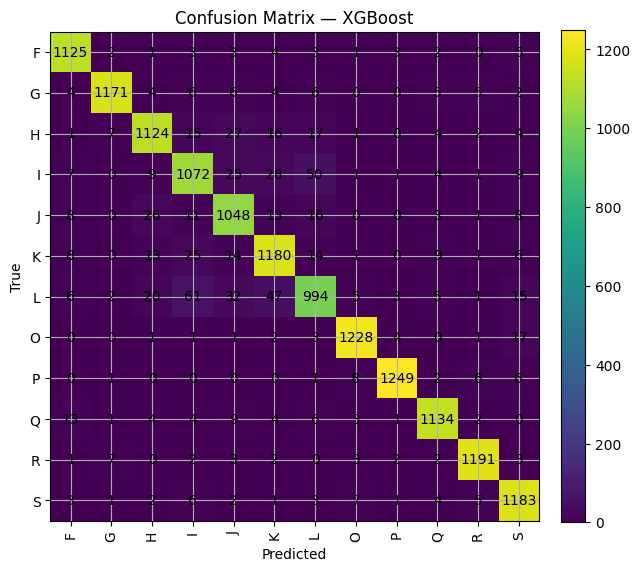

Leaderboard (sorted by F1-macro then Accuracy):
              model  accuracy  f1_macro  f1_weighted
       RandomForest  0.949009  0.948583     0.948846
            XGBoost  0.942678  0.942164     0.942525
       DecisionTree  0.896023  0.895557     0.895892
            SVM_RBF  0.744495  0.744780     0.746015
           AdaBoost  0.306634  0.299458     0.299593
NaiveBayes_Gaussian  0.165841  0.133096     0.134905


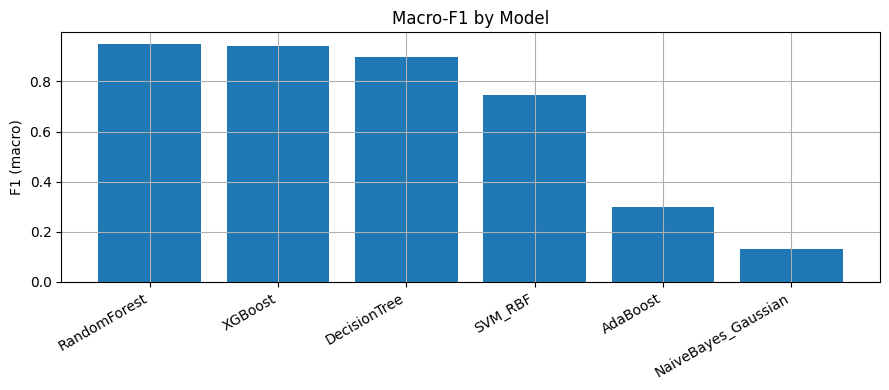

Deep Learning sequence shapes:
  X_train_seq: (50861, 180, 12)  y_train_int: (50861,)
  X_val_seq:   (10899, 180, 12)  y_val_int:   (10899,)
  X_test_seq:  (10899, 180, 12)  y_test_int:  (10899,)


In [14]:

## Task 6 — Classical ML Models + Deep Learning Input Prep (WISDM)
# Run these cells  after feature extraction.

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier


# ## 1) Single split shared by all classical models
# Keeps the comparison fair (same train/test across models).


# Encode string labels -> integers 0..C-1
le_global = LabelEncoder()
y_enc = le_global.fit_transform(y)          
class_names = le_global.classes_             
num_classes = len(class_names)

# Single split shared by all models
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(X_train.shape, X_test.shape, " | classes:", class_names)



# ## 2) Helper — evaluation & reporting
# Prints a classification report, draws a confusion matrix, and returns summary metrics.


def evaluate_model(model, name: str) -> Dict[str, Any]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    print("\n" + "="*80)
    print(f"Model: {name}")
    print("-"*80)
    print(classification_report(
        y_test, y_pred, target_names=class_names, digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
    fig, ax = plt.subplots(figsize=(6.5, 6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"Confusion Matrix — {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "estimator": model,
    }



# ## 3) Define classical models
# - Decision Tree
# - SVM (RBF) with `StandardScaler`
# - Gaussian Naive Bayes
# - Random Forest (balanced)
# - AdaBoost
# - XGBoost (if installed)

# Replace +/- inf with NaN so the imputer can handle them
X = np.where(np.isfinite(X), X, np.nan)

models = [
    ("DecisionTree", make_pipeline(
        SimpleImputer(strategy="median"),
        DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, random_state=42)
    )),

    ("SVM_RBF", make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(),
        SVC(C=10.0, kernel="rbf", gamma="scale", probability=False, random_state=42)
    )),

    ("NaiveBayes_Gaussian", make_pipeline(
        SimpleImputer(strategy="mean"),   
        GaussianNB()
    )),

    ("RandomForest", make_pipeline(
        SimpleImputer(strategy="median"),
        RandomForestClassifier(n_estimators=300, class_weight="balanced",
                               max_features="sqrt", random_state=42, n_jobs=-1)
    )),

    ("AdaBoost", make_pipeline(
    SimpleImputer(strategy="median"),
    AdaBoostClassifier(
        n_estimators=300,
        learning_rate=0.5,
        algorithm="SAMME",   
        random_state=42
        )
    )),

]


# XGBoost can handle NaNs but we keep imputer for consistency
models.append(("XGBoost", make_pipeline(
     SimpleImputer(strategy="median"),
    XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
        objective="multi:softmax", 
        num_class=len(np.unique(y)),  
        random_state=42, n_jobs=-1, tree_method="hist"
    )
)))



# ## 4) Train/evaluate all models + leaderboard
results = []
for name, est in models:
    try:
        res = evaluate_model(est, name)
        results.append(res)
    except Exception as e:
        print(f"[Warning] {name} failed: {e}")

leaderboard = pd.DataFrame(results).sort_values(by=["f1_macro", "accuracy"], ascending=False)
print("Leaderboard (sorted by F1-macro then Accuracy):")
print(leaderboard[["model", "accuracy", "f1_macro", "f1_weighted"]].to_string(index=False))

plt.figure(figsize=(9,4))
plt.bar(leaderboard["model"], leaderboard["f1_macro"])  
plt.title("Macro-F1 by Model")
plt.ylabel("F1 (macro)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# ## 5) Deep Learning input prep (sequences)
# Produces normalized sequences and encoded labels, with train/val/test splits.

# Encode labels to integers 0..C-1
le = LabelEncoder()
labels_int = le.fit_transform(labels)
class_names = list(le.classes_)
num_classes = len(class_names)

# Normalize per-channel over the entire dataset
win = windows.astype(np.float32)           
N, T, C = win.shape
ch_mean = win.reshape(-1, C).mean(axis=0)
ch_std  = win.reshape(-1, C).std(axis=0) + 1e-8
win_norm = (win - ch_mean) / ch_std

# One-hots (for Keras); integers are fine for PyTorch CE loss
enc = OneHotEncoder(sparse_output=False)
Y_onehot = enc.fit_transform(labels_int.reshape(-1,1))

X_train_seq, X_temp_seq, y_train_int, y_temp_int = train_test_split(
    win_norm, labels_int, test_size=0.3, random_state=42, stratify=labels_int
)
X_val_seq, X_test_seq, y_val_int, y_test_int = train_test_split(
    X_temp_seq, y_temp_int, test_size=0.5, random_state=42, stratify=y_temp_int
)

Y_train_oh = enc.transform(y_train_int.reshape(-1,1))
Y_val_oh   = enc.transform(y_val_int.reshape(-1,1))
Y_test_oh  = enc.transform(y_test_int.reshape(-1,1))

print("Deep Learning sequence shapes:")
print("  X_train_seq:", X_train_seq.shape, " y_train_int:", y_train_int.shape)
print("  X_val_seq:  ", X_val_seq.shape,   " y_val_int:  ", y_val_int.shape)
print("  X_test_seq: ", X_test_seq.shape,  " y_test_int: ", y_test_int.shape)

DL_META = {
    "class_names": class_names,
    "num_classes": num_classes,
    "seq_len": T,
    "num_channels": C,
    "channel_mean": ch_mean,
    "channel_std": ch_std,
}



Feature X shapes (classical ML split):
  X_train: (58127, 54)
  X_test:  (14532, 54)
  num_classes: 12
  class_names: ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'O', 'P', 'Q', 'R', 'S']
ANN feature input_dim: 54

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14080     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)       

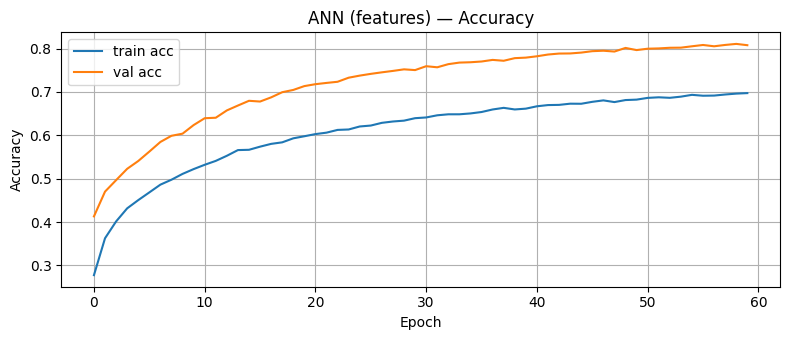

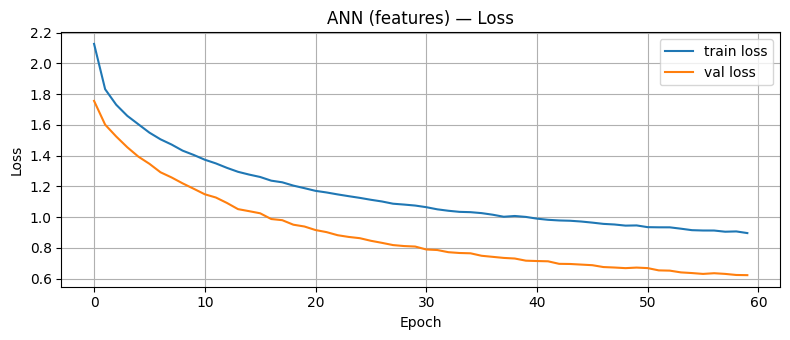


Test Accuracy (ANN_features): 0.8132
Test Loss (ANN_features):     0.6124
455/455 [==============================] - 0s 823us/step
Macro F1 (ANN_features):    0.8123
Weighted F1 (ANN_features): 0.8133

Classification report (ANN_features):
              precision    recall  f1-score   support

           F     0.7873    0.8932    0.8369      1152
           G     0.8656    0.8120    0.8379      1213
           H     0.8193    0.6962    0.7528      1218
           I     0.7231    0.7680    0.7449      1207
           J     0.6827    0.8157    0.7433      1134
           K     0.6933    0.7860    0.7367      1271
           L     0.7541    0.6129    0.6762      1191
           O     0.9502    0.8792    0.9133      1258
           P     0.9427    0.9301    0.9363      1273
           Q     0.8744    0.8019    0.8366      1181
           R     0.8244    0.8766    0.8497      1216
           S     0.8860    0.8801    0.8830      1218

    accuracy                         0.8132     14532
 

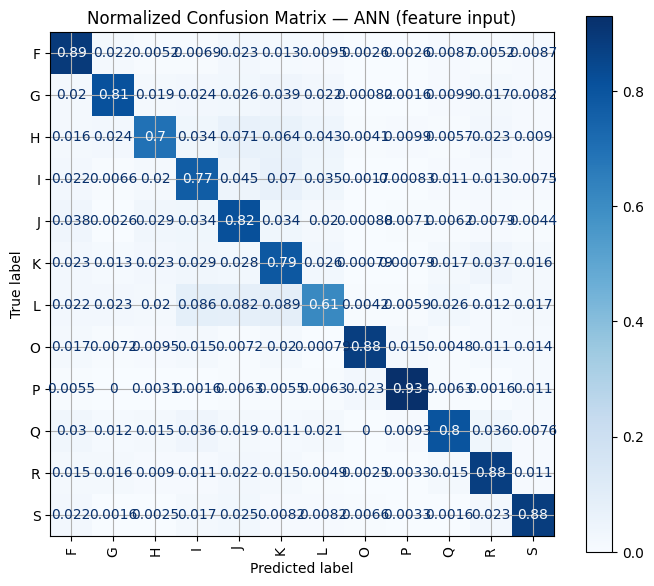

In [15]:
# ============================
# ANN on feature-engineered X
# ============================

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score
)

layers = keras.layers
models = keras.models
callbacks = keras.callbacks

print("Feature X shapes (classical ML split):")
print("  X_train:", X_train.shape)
print("  X_test: ", X_test.shape)
print("  num_classes:", num_classes)
print("  class_names:", class_names)

# ---- train/val split for ANN (from classical X_train) ----
X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ---- standardize features ----
scaler_ann = StandardScaler()
X_train_ann = scaler_ann.fit_transform(X_train_ann)
X_val_ann   = scaler_ann.transform(X_val_ann)
X_test_ann  = scaler_ann.transform(X_test)

input_dim_feat = X_train_ann.shape[1]
print("ANN feature input_dim:", input_dim_feat)

# ---- build ANN ----
tf.random.set_seed(42)

model_ann_feat = models.Sequential([
    layers.Input(shape=(input_dim_feat,)),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(num_classes, activation='softmax')
])

model_ann_feat.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',   # y_* are integer labels
    metrics=['accuracy']
)

model_ann_feat.summary()

# ---- early stopping ----
early_stop_feat = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ---- train ANN on features ----
history_ann_feat = model_ann_feat.fit(
    X_train_ann, y_train_ann,
    validation_data=(X_val_ann, y_val_ann),
    epochs=60,
    batch_size=128,
    callbacks=[early_stop_feat],
    verbose=1
)

# ---- training curves ----
hist_f = history_ann_feat.history

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
plt.plot(hist_f['accuracy'], label='train acc')
plt.plot(hist_f['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ANN (features) — Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3.5))
plt.plot(hist_f['loss'], label='train loss')
plt.plot(hist_f['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ANN (features) — Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- test performance on X_test_ann / y_test ----
test_loss_feat, test_acc_feat = model_ann_feat.evaluate(X_test_ann, y_test, verbose=0)
print(f"\nTest Accuracy (ANN_features): {test_acc_feat:.4f}")
print(f"Test Loss (ANN_features):     {test_loss_feat:.4f}")

y_proba_feat = model_ann_feat.predict(X_test_ann)
y_pred_feat  = np.argmax(y_proba_feat, axis=1)

f1_macro_feat    = f1_score(y_test, y_pred_feat, average='macro')
f1_weighted_feat = f1_score(y_test, y_pred_feat, average='weighted')

print(f"Macro F1 (ANN_features):    {f1_macro_feat:.4f}")
print(f"Weighted F1 (ANN_features): {f1_weighted_feat:.4f}")

print("\nClassification report (ANN_features):")
print(classification_report(
    y_test,
    y_pred_feat,
    target_names=class_names,
    digits=4,
    zero_division=0
))

# ---- confusion matrix for ANN on features ----
cm_feat = confusion_matrix(
    y_test, y_pred_feat,
    labels=np.arange(num_classes),
    normalize='true'
)

disp_feat = ConfusionMatrixDisplay(
    confusion_matrix=cm_feat,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(7, 6))
disp_feat.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=90, colorbar=True)
ax.set_title("Normalized Confusion Matrix — ANN (feature input)")
plt.tight_layout()
plt.show()


Leaderboard summary:

              model  accuracy  f1_macro  f1_weighted
       RandomForest  0.949009  0.948583     0.948846
            XGBoost  0.942678  0.942164     0.942525
       DecisionTree  0.896023  0.895557     0.895892
            SVM_RBF  0.744495  0.744780     0.746015
           AdaBoost  0.306634  0.299458     0.299593
NaiveBayes_Gaussian  0.165841  0.133096     0.134905


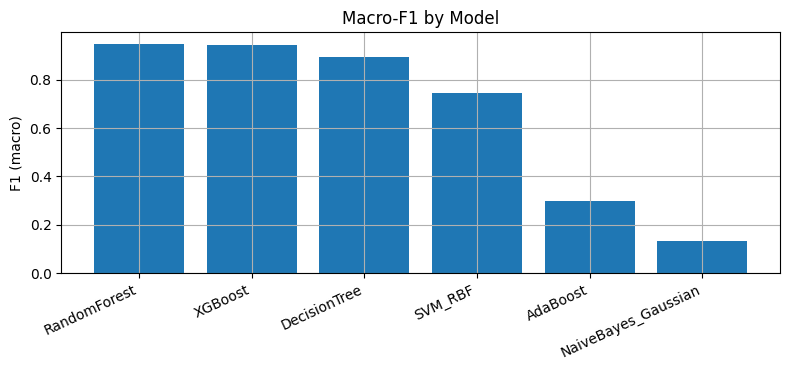

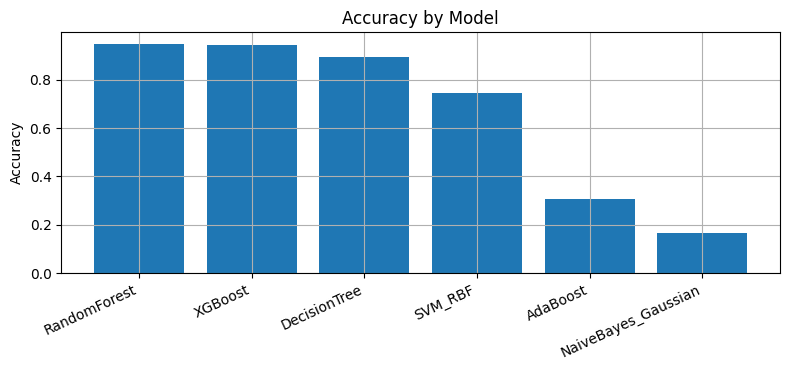

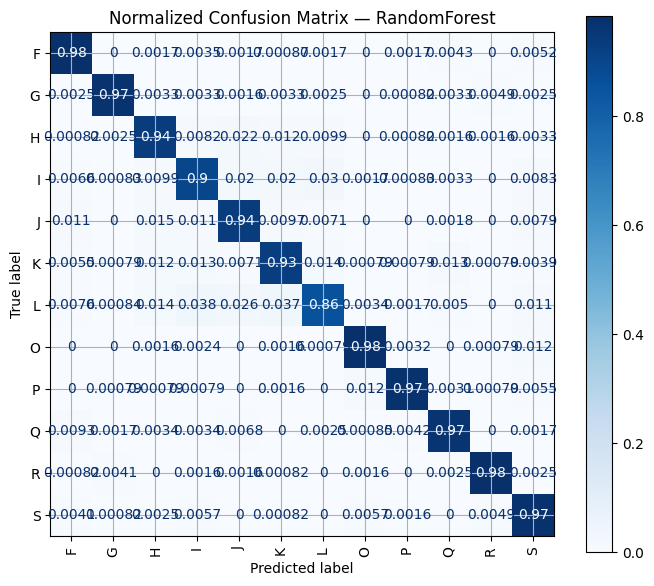

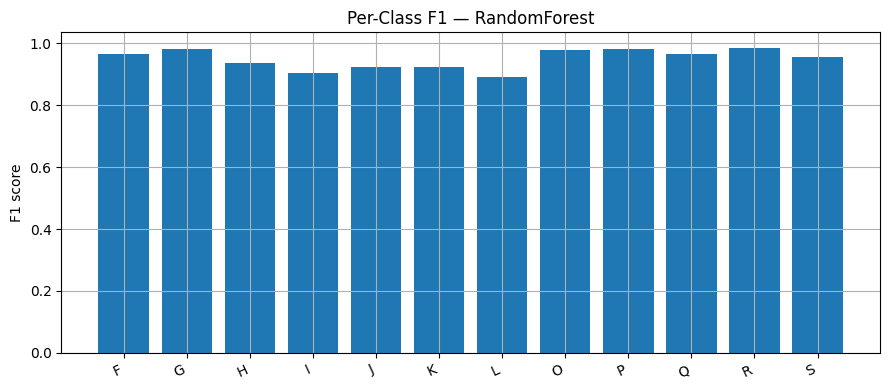

Best Model: RandomForest
Classification report (best model):
              precision    recall  f1-score   support

           F     0.9519    0.9792    0.9653      1152
           G     0.9874    0.9720    0.9796      1213
           H     0.9368    0.9368    0.9368      1218
           I     0.9095    0.8989    0.9042      1207
           J     0.9101    0.9374    0.9235      1134
           K     0.9184    0.9292    0.9237      1271
           L     0.9247    0.8556    0.8888      1191
           O     0.9746    0.9777    0.9762      1258
           P     0.9849    0.9749    0.9799      1273
           Q     0.9612    0.9661    0.9637      1181
           R     0.9860    0.9844    0.9852      1216
           S     0.9390    0.9737    0.9561      1218

    accuracy                         0.9490     14532
   macro avg     0.9487    0.9488    0.9486     14532
weighted avg     0.9490    0.9490    0.9488     14532



In [16]:

# # Task 9 — Report: Results Plots and Model Descriptions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support

# Safety: rebuild a compact results frame if needed
if 'leaderboard' not in globals() or leaderboard is None or leaderboard.empty:
    try:
        leaderboard = pd.DataFrame(results)
    except Exception:
        leaderboard = pd.DataFrame([])

if not leaderboard.empty:
    lb = leaderboard.copy()
    # Keep only public columns, sorted by macro-F1 then accuracy
    keep_cols = [c for c in ["model", "accuracy", "f1_macro", "f1_weighted"] if c in lb.columns]
    lb = lb[keep_cols].sort_values(["f1_macro", "accuracy"], ascending=False)
else:
    lb = pd.DataFrame([])

print("\nLeaderboard summary:\n")
if not lb.empty:
    print(lb.to_string(index=False))
else:
    print("No leaderboard found — run Task 6 first.")

# ## 9.1 Overall Performance Plots
# Bar charts for macro-F1 and accuracy across all classical models.

# %%
if not lb.empty:
    plt.figure(figsize=(8, 3.8))
    plt.bar(lb["model"], lb["f1_macro"])  # default colors only
    plt.title("Macro-F1 by Model")
    plt.ylabel("F1 (macro)")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 3.8))
    plt.bar(lb["model"], lb["accuracy"])  # default colors only
    plt.title("Accuracy by Model")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()


# ## 9.2 Best Model: Confusion Matrix & Per-Class Scores


if not lb.empty:
    # Find the stored estimator in `results` matching best by f1_macro
    best_name = lb.iloc[0]["model"]
    best_entry = None
    for r in results:
        if r.get("model") == best_name:
            best_entry = r
            break

    if best_entry is not None:
        best_est = best_entry["estimator"]
        # Access the global split from Task 6
        y_pred_best = best_est.predict(X_test)

        # Normalized confusion matrix
        # y_test / y_pred_best are integers 0..num_classes-1 from Task 6 (LabelEncoder)
        cm = confusion_matrix(
            y_test,
            y_pred_best,
            labels=np.arange(num_classes),   # <-- use encoded label indices
            normalize="true"
        )

        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=class_names       # <-- readable labels (e.g., ['F','G',...,'S'] or full names)
        )

        fig, ax = plt.subplots(figsize=(7, 6))
        disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=90, colorbar=True)
        ax.set_title(f"Normalized Confusion Matrix — {best_name}")
        plt.tight_layout()
        plt.show()


        # Per-class F1 bar chart
        labels_idx = np.arange(num_classes)  # 0..num_classes-1
        pr, rc, f1, sup = precision_recall_fscore_support(
            y_test, y_pred_best, labels=labels_idx, zero_division=0
        )

# Show codes (['F','G',...]) or map to full names if you have activity_code2name
        class_display = class_names  # or [activity_code2name.get(c, c) for c in class_names]

        plt.figure(figsize=(9, 4))
        plt.bar(range(num_classes), f1)              # numeric positions
        plt.xticks(range(num_classes), class_display, rotation=25, ha='right')
        plt.title(f"Per-Class F1 — {best_name}")
        plt.ylabel("F1 score")
        plt.tight_layout()
        plt.show()

        # Text report (for copy/paste into papers)
        print(f"Best Model: {best_name}")
        print("Classification report (best model):")
        print(classification_report(y_test, y_pred_best, target_names=class_names, digits=4))

    else:
        print("Could not locate the best estimator in `results`. Re-run Task 6.")
else:
    print("Leaderboard empty — run Task 6 first.")


In [17]:
# ============================
# Add ANN (features) to leaderboard
# ============================

import pandas as pd

ann_feat_entry = {
    "model": "ANN_features",
    "accuracy": float(test_acc_feat),
    "f1_macro": float(f1_macro_feat),
    "f1_weighted": float(f1_weighted_feat),
    "estimator": model_ann_feat,
}

# ensure `results` exists
if 'results' not in globals():
    results = []

results.append(ann_feat_entry)

leaderboard = pd.DataFrame(results).sort_values(
    by=["f1_macro", "accuracy"],
    ascending=False
)

print("\nUpdated leaderboard (including ANN_features):")
print(leaderboard[["model", "accuracy", "f1_macro", "f1_weighted"]].to_string(index=False))



Updated leaderboard (including ANN_features):
              model  accuracy  f1_macro  f1_weighted
       RandomForest  0.949009  0.948583     0.948846
            XGBoost  0.942678  0.942164     0.942525
       DecisionTree  0.896023  0.895557     0.895892
       ANN_features  0.813240  0.812311     0.813298
            SVM_RBF  0.744495  0.744780     0.746015
           AdaBoost  0.306634  0.299458     0.299593
NaiveBayes_Gaussian  0.165841  0.133096     0.134905


LOSO Evaluation

C:\Users\hanna\AppData\Local\Temp\ipykernel_21788\350303493.py:115: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hand[col] = df_hand[col].fillna(method="ffill").fillna(method="bfill")


Windows: (72659, 180, 12) Labels: (72659,) Users: (72659,)

Leaderboard (sorted by F1-macro then Accuracy):
               model  accuracy  f1_macro  f1_weighted
       Random Forest  0.448768  0.437843     0.438717
             XGBoost  0.424375  0.412767     0.412955
       Decision Tree  0.287512  0.278226     0.279596
             RBF SVM  0.277843  0.251198     0.254687
            AdaBoost  0.194326  0.127509     0.130645
Gaussian Naive Bayes  0.159545  0.105032     0.108885

Full metrics (means across LOSO folds):
               model  accuracy  precision   recall  f1_macro
       Random Forest  0.448768   0.486951 0.452220  0.437843
             XGBoost  0.424375   0.460077 0.427248  0.412767
       Decision Tree  0.287512   0.299574 0.289735  0.278226
             RBF SVM  0.277843   0.279941 0.277518  0.251198
            AdaBoost  0.194326   0.155761 0.191296  0.127509
Gaussian Naive Bayes  0.159545   0.137601 0.158075  0.105032


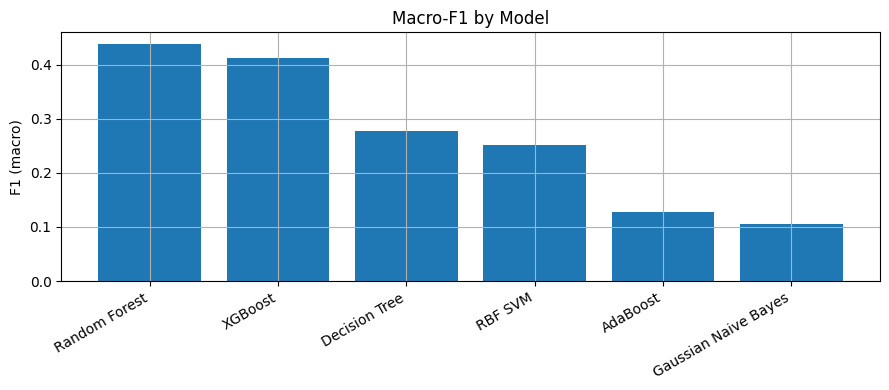


Deep Learning sequence shapes:
  X_train_seq: (50861, 180, 12)  y_train_int: (50861,)
  X_val_seq:   (10899, 180, 12)  y_val_int:   (10899,)
  X_test_seq:  (10899, 180, 12)  y_test_int:  (10899,)


In [ ]:
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq
from scipy.stats import iqr
from scipy.stats import entropy

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
    warnings.warn("XGBoost not available — will be skipped.")


# activity mapping
activity_code2name = {
    "A": "Walking",
    "B": "Jogging",
    "C": "Stairs",
    "D": "Sitting",
    "E": "Standing",
    "F": "Typing",
    "G": "Brushing teeth",
    "H": "Eating soup",
    "I": "Eating chips",
    "J": "Eating pasta",
    "K": "Drinking",
    "L": "Eating sandwich",
    "M": "Kicking (soccer ball)",
    "O": "Playing catch",
    "P": "Dribbling",
    "Q": "Writing",
    "R": "Clapping",
    "S": "Folding clothes",
}
activity_name2code = {v: k for k, v in activity_code2name.items()}

# activities to test
ALLOWED_CODES = ["F","G","H","I","J","K","L","O","P","Q","R","S"]


#loader
def load_raw_sensor(pattern, prefix):
    files = glob.glob(pattern)
    dfs = []

    for path in files:
        with open(path, 'r') as f:
            first_line = f.readline()

        skip_rows = 0
        if first_line.startswith('version https://git-lfs.github.com/spec/v1'):
            skip_rows = 3

        df = pd.read_csv(
            path,
            header=None,
            names=["user", "activity", "timestamp", "x", "y", "z"],
            skiprows=skip_rows
        )
        df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)
        df[["x","y","z"]] = df[["x","y","z"]].astype(float)

        df = df.rename(columns={
            "x": f"{prefix}_x",
            "y": f"{prefix}_y",
            "z": f"{prefix}_z",
        })
        dfs.append(df)

    if not dfs:
        return pd.DataFrame(columns=["user","activity","timestamp", f"{prefix}_x", f"{prefix}_y", f"{prefix}_z"])
    return pd.concat(dfs, ignore_index=True)


# filter and preprocess
FS = 20  # sampling rate used for frequency features

def butter_lowpass_filter(x, cutoff=5, fs=FS, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low")
    return filtfilt(b, a, x)


# load and merge sensors
watch_acc  = load_raw_sensor("wisdm-dataset/raw/watch/accel/*.txt", "w_acc")
watch_gyro = load_raw_sensor("wisdm-dataset/raw/watch/gyro/*.txt",  "w_gyro")
phone_acc  = load_raw_sensor("wisdm-dataset/raw/phone/accel/*.txt", "p_acc")
phone_gyro = load_raw_sensor("wisdm-dataset/raw/phone/gyro/*.txt",  "p_gyro")

df_all = watch_acc.merge(watch_gyro, on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_acc,  on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_gyro, on=["user","activity","timestamp"], how="outer")

df_all["activity"] = df_all["activity"].astype(str).str.strip()

# filter only hand activities
df_hand = df_all[df_all["activity"].isin(ALLOWED_CODES)].copy().reset_index(drop=True)

# expected sensor columns
sensor_cols = [
    "w_acc_x","w_acc_y","w_acc_z",
    "w_gyro_x","w_gyro_y","w_gyro_z",
    "p_acc_x","p_acc_y","p_acc_z",
    "p_gyro_x","p_gyro_y","p_gyro_z"
]

# ensure columns exist
for c in sensor_cols:
    if c not in df_hand.columns:
        df_hand[c] = np.nan

# interpolate & filter per column
for col in sensor_cols:
    df_hand[col] = df_hand[col].interpolate(method="linear", limit_direction="both")
    df_hand[col] = df_hand[col].fillna(method="ffill").fillna(method="bfill")
    if df_hand[col].notna().sum() >= 5:
        try:
            df_hand[col] = butter_lowpass_filter(df_hand[col].values)
        except Exception:
            pass


# windowing
def create_windows(df, window_size=200, overlap=0.5):
    step = int(window_size * (1.0 - overlap))
    if step <= 0:
        raise ValueError("overlap must be < 1.0 and window_size positive")

    X, y, users = [], [], []

    df_sorted = df.sort_values(["user","activity","timestamp"]).reset_index(drop=True)
    signals = df_sorted[sensor_cols].values
    acts = df_sorted["activity"].values
    us = df_sorted["user"].values

    for start in range(0, len(df_sorted) - window_size + 1, step):
        end = start + window_size
        window = signals[start:end]
        if window.shape[0] != window_size:
            continue
        label = pd.Series(acts[start:end]).mode()[0]
        user_val = pd.Series(us[start:end]).mode()[0]

        X.append(window)
        y.append(label)
        users.append(user_val)

    return np.array(X), np.array(y), np.array(users)


# helpers for feature extraction
def time_features_1d(x):
    mean = np.mean(x)
    sd   = np.std(x)
    rms  = np.sqrt(np.mean(x**2))

    signs = np.sign(x)
    signs[signs == 0] = 1
    zcr = np.sum(signs[1:] != signs[:-1]) / len(x)

    return [mean, sd, rms, zcr]


def freq_features_1d(x, fs=FS):
    N = len(x)
    yf = rfft(x)
    xf = rfftfreq(N, 1.0 / fs)

    power = np.abs(yf) ** 2

    if len(power) > 1:
        idx = np.argmax(power[1:]) + 1
    else:
        idx = 0
    dom_freq = xf[idx] if idx < len(xf) else 0.0

    energy = np.sum(power)

    p = power / (energy + 1e-12)
    ent = -np.sum(p * np.log(p + 1e-12))

    return [dom_freq, energy, ent]


def extract_features_window(window):
    feats = []
    for c in range(window.shape[1]): 
        x = window[:, c].astype(float)
        feats.extend(time_features_1d(x))
        feats.extend(freq_features_1d(x))
    return np.array(feats, dtype=float)


# build windows and features
WINDOW_SIZE = 180
OVERLAP = 0.5

windows, labels, users = create_windows(df_hand, window_size=WINDOW_SIZE, overlap=OVERLAP)
print("Windows:", windows.shape, "Labels:", labels.shape, "Users:", users.shape)

if len(windows) == 0:
    raise RuntimeError("No windows created.")

X = np.array([extract_features_window(w) for w in windows], dtype=float)
y_raw = np.array(labels)
groups = np.array(users)

X = np.where(np.isfinite(X), X, np.nan)

# encode labels
le = LabelEncoder()
labels_int = le.fit_transform(y_raw)
class_names = list(le.classes_)
num_classes = len(class_names)

# models to test
models = []
models.append(("Random Forest", RandomForestClassifier(
    n_estimators=300, class_weight="balanced", max_features="sqrt", random_state=42, n_jobs=-1)))
if XGB_AVAILABLE:
    models.append(("XGBoost", xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, objective="multi:softmax",
        eval_metric="mlogloss", n_jobs=-1, random_state=42)))
models.append(("Decision Tree", DecisionTreeClassifier(max_depth=None, class_weight="balanced", random_state=42)))
models.append(("RBF SVM", SVC(kernel="rbf", C=5, gamma="scale", class_weight="balanced")))
models.append(("AdaBoost", AdaBoostClassifier(n_estimators=300, learning_rate=0.05, random_state=42)))
models.append(("Gaussian Naive Bayes", GaussianNB()))


# evaluate models with LOSO
logo = LeaveOneGroupOut()

def evaluate_model(estimator, name):
    """
    Perform LOSO across 'groups' array and return mean metrics.
    Returns a dict with keys: model, accuracy, precision, recall, f1_macro, f1_weighted
    """
    pipe = make_pipeline(SimpleImputer(strategy="median"), estimator)

    acc_list, prec_list, rec_list, f1_macro_list, f1_weighted_list = [], [], [], [], []

    # iterate LOSO splits
    for train_idx, test_idx in logo.split(X, labels_int, groups=groups):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = labels_int[train_idx], labels_int[test_idx]

        try:
            pipe.fit(X_tr, y_tr)
            y_pred = pipe.predict(X_te)
        except Exception as e:
            y_pred = np.zeros_like(y_te)

        acc_list.append(accuracy_score(y_te, y_pred))
        prec_list.append(precision_score(y_te, y_pred, average="macro", zero_division=0))
        rec_list.append(recall_score(y_te, y_pred, average="macro", zero_division=0))
        f1_macro_list.append(f1_score(y_te, y_pred, average="macro", zero_division=0))
        f1_weighted_list.append(f1_score(y_te, y_pred, average="weighted", zero_division=0))

    return {
        "model": name,
        "accuracy": float(np.mean(acc_list)),
        "precision": float(np.mean(prec_list)),
        "recall": float(np.mean(rec_list)),
        "f1_macro": float(np.mean(f1_macro_list)),
        "f1_weighted": float(np.mean(f1_weighted_list)),
    }


# train and evaluate all models
results = []
for name, est in models:
    try:
        res = evaluate_model(est, name)
        results.append(res)
    except Exception as e:
        print(f"[Warning] {name} failed: {e}")

leaderboard = pd.DataFrame(results).sort_values(by=["f1_macro", "accuracy"], ascending=False)
print("\nLeaderboard (sorted by F1-macro then Accuracy):")
print(leaderboard[["model", "accuracy", "f1_macro", "f1_weighted"]].to_string(index=False))

print("\nFull metrics (means across LOSO folds):")
print(leaderboard[["model", "accuracy", "precision", "recall", "f1_macro"]].to_string(index=False))

plt.figure(figsize=(9,4))
plt.bar(leaderboard["model"], leaderboard["f1_macro"])
plt.title("Macro-F1 by Model")
plt.ylabel("F1 (macro)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# deep learning prep
win = windows.astype(np.float32)
N, T, C = win.shape
ch_mean = win.reshape(-1, C).mean(axis=0)
ch_std  = win.reshape(-1, C).std(axis=0) + 1e-8
win_norm = (win - ch_mean) / ch_std

enc = OneHotEncoder(sparse_output=False)
Y_onehot = enc.fit_transform(labels_int.reshape(-1,1))

X_train_seq, X_temp_seq, y_train_int, y_temp_int = train_test_split(
    win_norm, labels_int, test_size=0.3, random_state=42, stratify=labels_int
)
X_val_seq, X_test_seq, y_val_int, y_test_int = train_test_split(
    X_temp_seq, y_temp_int, test_size=0.5, random_state=42, stratify=y_temp_int
)

Y_train_oh = enc.transform(y_train_int.reshape(-1,1))
Y_val_oh   = enc.transform(y_val_int.reshape(-1,1))
Y_test_oh  = enc.transform(y_test_int.reshape(-1,1))

print("\nDeep Learning sequence shapes:")
print("  X_train_seq:", X_train_seq.shape, " y_train_int:", y_train_int.shape)
print("  X_val_seq:  ", X_val_seq.shape,   " y_val_int:  ", y_val_int.shape)
print("  X_test_seq: ", X_test_seq.shape,  " y_test_int: ", y_test_int.shape)

DL_META = {
    "class_names": class_names,
    "num_classes": num_classes,
    "seq_len": T,
    "num_channels": C,
    "channel_mean": ch_mean,
    "channel_std": ch_std,
}